# 06 — Basic Machine Learning

*Clean, principled ML workflows that we’ll reuse for RL critics, reward models, and diagnostics.*

**What you'll learn**
- Regression: linear models, train/test split, and error metrics (MSE/MAE/$R^2$).
- Classification: logistic regression / SVC, accuracy vs. precision/recall/F1, ROC–AUC.
- Model validation: cross-validation, bias–variance intuition, and over/underfitting.
- Good hygiene: feature scaling, pipelines, and reproducible experiments.

> Critics are regressors; policies are classifiers over discrete actions (softmax). Getting ML right makes RL training far easier to debug.

## 0. Introduction to Machine Learning

**Machine Learning (ML)** is the study of algorithms that learn patterns from data and make predictions or decisions without being explicitly programmed.  
At its core, ML is about **mapping inputs to outputs** using data-driven optimization.

Formally, given data samples  
$$
\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N,
$$  
ML finds parameters $ \theta $ of a function $ f_\theta(x) $ that minimize a **loss** measuring the discrepancy between predictions and ground truth:  
$$
\min_\theta \; \frac{1}{N} \sum_{i=1}^N \mathcal{L}(f_\theta(x_i), y_i).
$$

Depending on the type of target $y_i$:  
- **Regression:** $y_i \in \mathbb{R}$ → predict continuous values.  
- **Classification:** $y_i \in \{1, \ldots, K\}$ → predict class probabilities.  
- **Clustering / Unsupervised:** no $y_i$, learn latent structure.  

**RL Connection:**  
In Reinforcement Learning, these same principles reappear —  
- *Value functions* are **regressors** (predicting expected returns).  
- *Policies* are **classifiers** (predicting action probabilities).  
- *Reward models* and *critics* use standard ML losses (MSE, cross-entropy) to learn from interaction data.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

## 1. Regression — Theory

Given input–target pairs $ \{(x_i, y_i)\}_{i=1}^N $ with $y_i \in \mathbb{R}$, a regressor $f_\theta(x)$ is trained by minimizing an error objective, commonly **Mean Squared Error (MSE)**:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \big(f_\theta(x_i) - y_i\big)^2.
$$

Other useful metrics include:
- **MAE:** $ \frac{1}{N}\sum_i |f_\theta(x_i)-y_i| $ (robust to outliers)  
- **$R^2$:** $ 1 - \frac{\sum_i (y_i-\hat y_i)^2}{\sum_i (y_i-\bar y)^2} $ (explained variance)

**Scaling matters:** Feature normalization often improves gradient convergence and model stability.

**RL Connection:**  
Regression is fundamental in RL — critics and Q-functions predict expected returns $ \hat{V}(s) \approx \mathbb{E}[G_t | S_t=s] $, optimizing the same MSE loss as standard regression models.

LinearRegression: {'MSE': 2848.311, 'MAE': 41.549, 'R2': 0.485}
Ridge(alpha=1.0): {'MSE': 2842.835, 'MAE': 41.507, 'R2': 0.486}


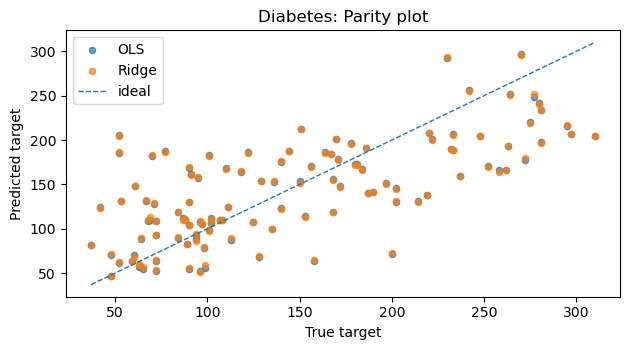

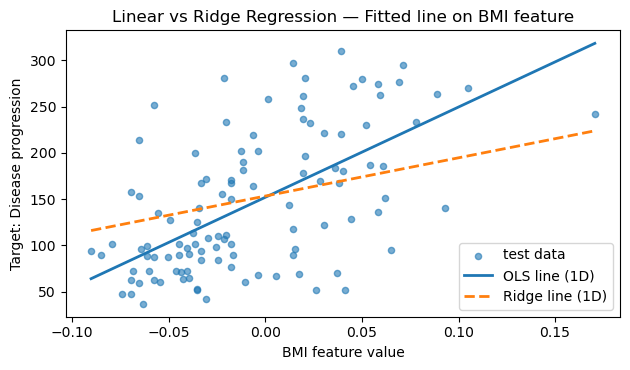

In [7]:
# LinearRegression vs Ridge on Diabetes dataset

# Reproducibility
np.random.seed(0)

# Data
X, y = datasets.load_diabetes(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipelines
pipe_ols = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0, random_state=42))
])

# Fit
pipe_ols.fit(X_tr, y_tr)
pipe_ridge.fit(X_tr, y_tr)

# Predict
y_pred_ols = pipe_ols.predict(X_te)
y_pred_rdg = pipe_ridge.predict(X_te)

# Metrics helper
def report(y_true, y_pred):
    return {
        "MSE": round(mean_squared_error(y_true, y_pred), 3),
        "MAE": round(mean_absolute_error(y_true, y_pred), 3),
        "R2":  round(r2_score(y_true, y_pred), 3),
    }

print("LinearRegression:", report(y_te, y_pred_ols))
print("Ridge(alpha=1.0):", report(y_te, y_pred_rdg))

# Parity (y_true vs y_pred)
plt.figure(figsize=(6.4, 3.6))
plt.scatter(y_te, y_pred_ols, s=20, alpha=0.7, label="OLS")
plt.scatter(y_te, y_pred_rdg, s=20, alpha=0.7, label="Ridge")
lims = [min(y_te.min(), y_pred_ols.min(), y_pred_rdg.min()),
        max(y_te.max(), y_pred_ols.max(), y_pred_rdg.max())]
plt.plot(lims, lims, linestyle="--", linewidth=1, label="ideal")
plt.title("Diabetes: Parity plot")
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.legend()
plt.tight_layout()
plt.show()

# Fitted line on a single feature (BMI) for intuition
# Choosing one interpretable feature (BMI is feature index 2 in the diabetes dataset)
feature_idx = 2  # BMI
X_tr_feat = X_tr[:, feature_idx].reshape(-1, 1)
X_te_feat = X_te[:, feature_idx].reshape(-1, 1)

# Fit simple 1D regressors for visualization
lr_1d = LinearRegression().fit(X_tr_feat, y_tr)
ridge_1d = Ridge(alpha=1.0).fit(X_tr_feat, y_tr)

# Build a smooth grid over the test feature range
x_min = X_te_feat.min()
x_max = X_te_feat.max()
X_line = np.linspace(x_min, x_max, 200).reshape(-1, 1)

y_line_lr = lr_1d.predict(X_line)
y_line_ridge = ridge_1d.predict(X_line)

plt.figure(figsize=(6.4, 3.8))
plt.scatter(X_te_feat, y_te, s=20, alpha=0.6, label="test data")
plt.plot(X_line, y_line_lr, label="OLS line (1D)", lw=2)
plt.plot(X_line, y_line_ridge, label="Ridge line (1D)", lw=2, linestyle="--")
plt.title("Linear vs Ridge Regression — Fitted line on BMI feature")
plt.xlabel("BMI feature value")
plt.ylabel("Target: Disease progression")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Classification — Theory

In **classification**, we predict discrete class labels $ y \in \{1, 2, \dots, K\} $ given input features $ x $.  
The model outputs **class probabilities** $ p_\theta(y \mid x) $, and training seeks to minimize the **cross-entropy loss**:

$$
\mathcal{L}(\theta)
= -\frac{1}{N} \sum_{i=1}^N \log p_\theta(y_i \mid x_i)
$$

For binary classification (e.g., logistic regression),  
$$
p_\theta(y=1 \mid x) = \sigma(w^\top x + b),
$$
where $ \sigma(z) = \frac{1}{1 + e^{-z}} $ is the **sigmoid function**.


### Key Evaluation Metrics

| Metric | Formula / Idea | Use |
|---------|----------------|-----|
| **Accuracy** | $ \frac{\text{\# correct}}{\text{\# total}} $ | Quick global metric |
| **Precision / Recall / F1** | Precision = $ \frac{TP}{TP + FP} $; Recall = $ \frac{TP}{TP + FN} $ | Handle class imbalance |
| **ROC–AUC** | Area under ROC curve | Measures threshold-independent ranking ability |


### Practical Tips

- **Feature scaling** is crucial for gradient-based models (e.g., Logistic Regression, SVM).  
- Use **Pipelines** to ensure preprocessing (e.g., `StandardScaler`) occurs inside cross-validation folds → prevents **data leakage**.  
- In multi-class problems, **softmax regression** generalizes logistic regression.


### RL Connection

Classification concepts directly transfer to RL tasks:
- **Policy Learning:** A stochastic policy $ \pi(a|s) $ predicts *action probabilities* — like a softmax classifier over actions.  
- **Reward Classification:** In inverse RL or preference learning, models classify which actions lead to higher returns.  
- **Exploration:** Action distributions with entropy regularization resemble probabilistic classifiers balancing exploration vs. exploitation.

{'accuracy': 0.9211, 'precision': 0.9246, 'recall': 0.9231, 'f1': 0.923}
Macro ROC-AUC (OvR): 0.996


/opt/miniconda3/envs/rlfs/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


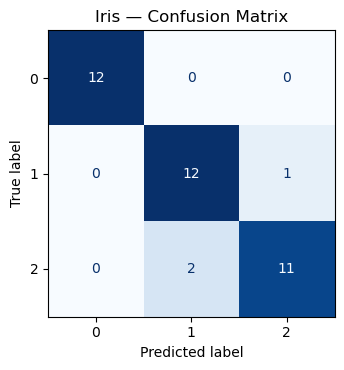

In [10]:
# Data
X, y = datasets.load_iris(return_X_y=True)
classes = np.unique(y)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Model (multinomial softmax)
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="lbfgs", multi_class="multinomial",
        max_iter=1000, random_state=42
    ))
])
clf.fit(X_tr, y_tr)

# Predictions + metrics
y_hat = clf.predict(X_te)
proba = clf.predict_proba(X_te)

acc = accuracy_score(y_te, y_hat)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_te, y_hat, average="macro"
)
print({"accuracy": round(acc, 4),
       "precision": round(prec, 4),
       "recall": round(rec, 4),
       "f1": round(f1, 4)})

# ROC–AUC (one-vs-rest): plot per class and macro AUC
y_te_binarized = label_binarize(y_te, classes=classes)  # shape (n_samples, n_classes)

# Macro AUC
macro_auc = roc_auc_score(y_te_binarized, proba, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC (OvR): {macro_auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_te, y_hat, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(4.8, 3.8))
disp.plot(ax=ax, colorbar=False, cmap="Blues")
plt.title("Iris — Confusion Matrix")
plt.tight_layout()
plt.show()

## 3. Model Validation — Cross-Validation & Bias–Variance

In **machine learning**, we aim to estimate how well a model generalizes to unseen data.  
Simple train–test splits can be unreliable for small datasets — **Cross-Validation (CV)** mitigates this by averaging performance across multiple folds.

### Cross-Validation (CV)
Data is divided into $K$ folds:
1. Train on $K-1$ folds.
2. Validate on the remaining fold.
3. Repeat for all folds and average results.

The best hyperparameters are chosen by maximizing average validation score:
$$
\theta^* = \arg\max_\theta \frac{1}{K} \sum_{k=1}^K \text{Score}_k(\theta)
$$

This ensures a more stable estimate of model performance and reduces dependence on any single data split.


### Bias–Variance Trade-off
The **total prediction error** can be decomposed as:
$$
\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Noise}.
$$
- **High Bias:** The model is too simple → underfitting.
- **High Variance:** The model is too flexible → overfitting.
- **Regularization (e.g., Ridge’s α):** adds penalty to reduce variance while maintaining fit.

Balancing both is key to strong generalization — tuning hyperparameters via CV directly controls this balance.


### RL Connection
Cross-validation parallels evaluation in Reinforcement Learning:
- RL agents require **policy evaluation** (e.g., Monte Carlo rollouts) to estimate performance.
- Bias–variance trade-offs appear in **value estimation**:  
  - *Monte Carlo* → low bias, high variance.  
  - *Temporal Difference (TD)* → higher bias, lower variance.  
  - *λ-returns* interpolate between the two, analogous to regularization in supervised learning.

Both domains rely on the same principle: balancing **fit vs. stability** for optimal generalization and learning efficiency.

Best params: {'svc__C': 5, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score: 0.9829
Test accuracy: 0.98

Top 3 CV configs:
  mean=0.9829 ± 0.0038 | {'svc__C': 5, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
  mean=0.9822 ± 0.0044 | {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
  mean=0.9814 ± 0.0041 | {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


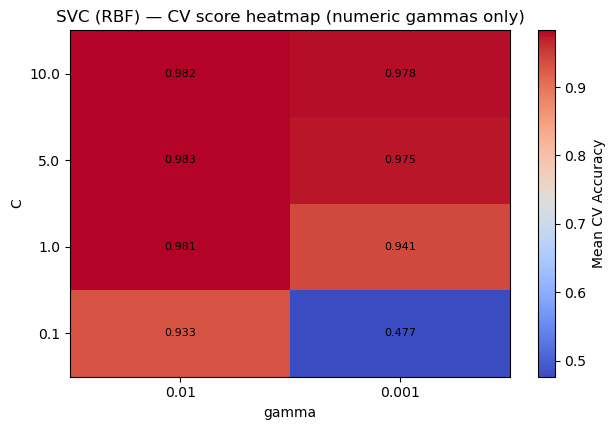

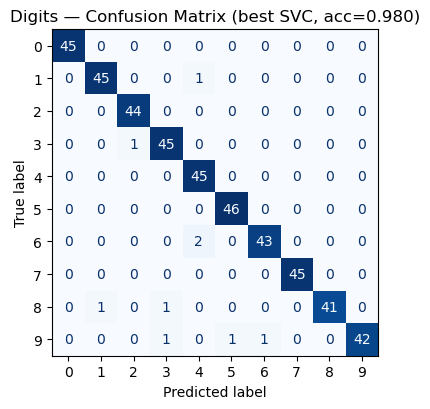

In [13]:
# SVC model selection with GridSearchCV — reports + heatmap + confusion matrix

# Data
X, y = datasets.load_digits(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0
)

# Pipeline + Grid
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])
param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 5, 10],
    "svc__gamma": ["scale", 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

# Fit search
search.fit(X_tr, y_tr)

print("Best params:", search.best_params_)
print("Best CV score:", round(search.best_score_, 4))

# Test-set evaluation
best = search.best_estimator_
y_hat = best.predict(X_te)
test_acc = accuracy_score(y_te, y_hat)
print("Test accuracy:", round(test_acc, 4))

# Top-3 CV configs
order = np.argsort(-search.cv_results_["mean_test_score"])
print("\nTop 3 CV configs:")
for i in order[:3]:
    params = search.cv_results_["params"][i]
    mean = search.cv_results_["mean_test_score"][i]
    std  = search.cv_results_["std_test_score"][i]
    print(f"  mean={mean:.4f} ± {std:.4f} | {params}")

# Heatmap of CV score over (C, gamma) for numeric gammas only
Cs = np.array([0.1, 1, 5, 10], dtype=float)
gammas_num = np.array([0.01, 0.001], dtype=float)

# Build score matrix [len(Cs) x len(gammas_num)]
score_mat = np.full((len(Cs), len(gammas_num)), np.nan, dtype=float)
params_list = search.cv_results_["params"]
means = search.cv_results_["mean_test_score"]

for p, m in zip(params_list, means):
    C = p["svc__C"]
    gamma = p["svc__gamma"]
    if isinstance(gamma, float) or isinstance(gamma, int):
        # locate indices
        i = np.where(Cs == float(C))[0]
        j = np.where(gammas_num == float(gamma))[0]
        if i.size and j.size:
            score_mat[i[0], j[0]] = m

plt.figure(figsize=(6.4, 4.4))
im = plt.imshow(score_mat, origin="lower", aspect="auto", cmap="coolwarm",)
plt.colorbar(im, label="Mean CV Accuracy")
plt.xticks(ticks=np.arange(len(gammas_num)), labels=[str(g) for g in gammas_num])
plt.yticks(ticks=np.arange(len(Cs)), labels=[str(c) for c in Cs])
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("SVC (RBF) — CV score heatmap (numeric gammas only)")
# annotate cells
for i in range(len(Cs)):
    for j in range(len(gammas_num)):
        val = score_mat[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()


# Confusion matrix on test set
cm = confusion_matrix(y_te, y_hat, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots(figsize=(5.2, 4.2))
disp.plot(ax=ax, colorbar=False, cmap="Blues")
plt.title(f"Digits — Confusion Matrix (best SVC, acc={test_acc:.3f})")
plt.tight_layout()
plt.show()

## 4. RL Tie‑In (Why this matters)

- **Critics as Regressors:** value/Q estimates minimize squared TD errors (an MSE).  
- **Policies as Classifiers:** discrete actions often use a softmax head; evaluation benefits from precision/recall-like diagnostics when actions are imbalanced.  
- **Validation Mindset:** although RL is non‑IID, careful train/validation splits for **offline RL** or synthetic rollouts help compare algorithms fairly.  
- **Pipelines & Scaling:** the same preprocessing discipline reduces instability when training function approximators in RL.

## Key Takeaways

- **Regression:** Evaluate models with $MSE$, $MAE$, and $ R^2 $; use regularization (Ridge/Lasso) to manage bias–variance trade-offs.  
- **Classification:** Go beyond accuracy—analyze confusion matrices, precision/recall/F1, and ROC–AUC for a full performance picture.  
- **Validation:** Apply cross-validation to select hyperparameters robustly and avoid overfitting.  
- **Best Practices:** Pipelines ensure clean preprocessing, prevent data leakage, and keep experiments reproducible across tasks.  

**Next:** `07_basic_deep_learning.ipynb` → Build intuition for neurons, MLPs, and CNNs as foundations for deep RL.